In [82]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [70]:

import copy
from PIL import Image

import glob

import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)

images = []
labels = []
classes = set()

image_width = 30
image_height = 30

sizes = {}

for filename in data_dir.glob('*/*.*'):
    class_name = str(filename).split("/")[1]
    classes.add(class_name)
    im = copy.deepcopy(Image.open(filename))

    str_size = im.size
    str_size = "x".join(map(str,im.size))
    if str_size not in sizes:
        sizes[str_size] = 1
    else:
        sizes[str_size] += 1
    
    im = im.resize((image_width,image_height)).convert('LA')
    #print(np.array(im).shape)
    images.append(np.array(im)[...,:1].reshape((image_width*image_height*1,)))
    #print(images[0].shape)
    labels.append(class_name)
    im.close()


classes = sorted(list(classes))
labels = [i for x in labels for i in range(len(classes)) if x == classes[i]]


Total no of images = 9008


## Image Example for each class
Although not all images have the same size, we will be displaying one image per class.

## Image Distribution across classes

<BarContainer object of 16 artists>

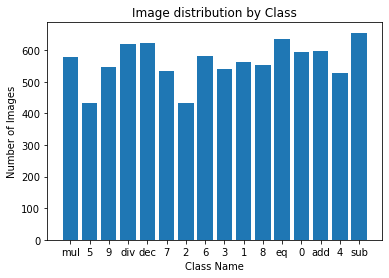

In [52]:
label_distribution = {}
for label in labels:
    if classes[label] not in label_distribution:
        label_distribution[classes[label]] = 1
    else:
        label_distribution[classes[label]] += 1

plt.title("Image distribution by Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.bar(label_distribution.keys(), label_distribution.values())

## Image Size Distribution

<BarContainer object of 8 artists>

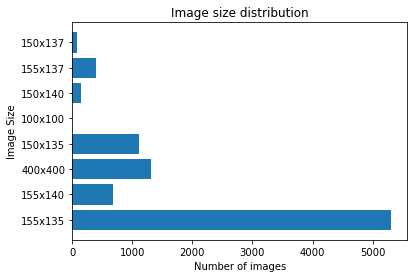

In [53]:
plt.title("Image size distribution")
plt.xlabel("Number of images")
plt.ylabel("Image Size")
plt.barh(list(sizes.keys()), sizes.values())

(9008, 900)


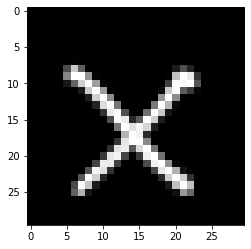

In [71]:
dataX = np.array(images).reshape((len(images), images[0].shape[0]))


#dataX[dataX <  128] = 0
#dataX[dataX >= 128] = 1
dataX = 1 - dataX / 255

plt.imshow(dataX[0].reshape(image_width, image_height), cmap="gray")

dataY = np.array(labels).reshape((len(labels),1))
print(dataX.shape)

In [55]:
print(dataX.shape)
print(dataY.shape)


(9008, 900)
(9008, 1)


In [72]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

5404 1802 1802


In [57]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(5404, 900)
(1802, 900)
(1802, 900)


In [6]:
# Add sigmoid FUNCTION from the previous lab

def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz= 1/(1+np.exp(-z))
    
    return gz

In [11]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m=len(X)
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((X.shape[0],1)),X,axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)

In [7]:
# Add costFunctionReg FUNCTION from the previous lab (the function that computes the regularized cost and the gradients)
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m=len(y)
        
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [8]:
# Add gradientDescent FUNCTION from the previous lab (the function that returns the optimal theta vector and J_history)
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        theta = theta - alpha*grad        
        
        J_history.append(cost)
    
    return theta , J_history


In [9]:
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K, breakpoint=10):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    all_val_pred = []
    all_train_pred = []
    
    #number of training examples
    m= len(X)
    
    #number of features
    n= X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X= np.append(np.ones((X.shape[0],1)),X,axis=1) 
    
    num_iters_b = num_iters//breakpoint
    theta_lst = [initial_theta for k in range(K)]
    
    for j in range(num_iters_b):
        all_theta = []
        
        for i in range(0,K):
            theta , J_history = gradientDescent(X,np.where(y==i,1,0),theta_lst[i],alpha,breakpoint,Lambda)

            theta_lst[i] = theta
            #update (extend)
            all_theta.extend(theta) 

            #update (extend)
            all_J.extend(J_history)
        
        pred_train = predictOneVsAll(np.array(all_theta).reshape(K,n+1), x_train)
        m = len(y_train)
        pred_train= pred_train.reshape((len(x_train),1))
        all_train_pred.append(sum(np.equal(pred_train,y_train))[0]/m)
        
        pred_val = predictOneVsAll(np.array(all_theta).reshape(K,n+1), x_val)
        m = len(y_val)
        pred_val= pred_val.reshape((len(x_val),1))
        all_val_pred.append(sum(np.equal(pred_val,y_val))[0]/m)
        
        
        
    return np.array(all_theta).reshape(K,n+1), all_J, all_train_pred, all_val_pred, pred_train, pred_val

In [77]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [25]:
#Inicialize vector theta =0
initial_theta = np.zeros((x_train.shape[1]+1,1))

#Optimization hyper-parameters 
alphas=[0.001,0.01, 0.1, 0.3, 0.5, 1, 2, 5] #learning rate
num_iters=1000
Lambda=0
print(len(y_train))
breakpoint = 100
# 4_% __%  30x30  round 1  zeros  0.1    300  0.1
# 46% 46%  30x30  round 1  zeros  0.1   1000  0.1
# 34% 38%  30x30  round 2  zeros  0.01   400  0.1
# 23% __%  40x40  round 1  zeros  0.1   1000  0.1
# 32% 23%  40x40  round 2  zeros  0.1   1000  0.1
# 39% 40%  40x40  round 2  zeros  0.01   400  0.1




    

5404


0.001
0.01
0.1
0.3
0.5
1
2
5


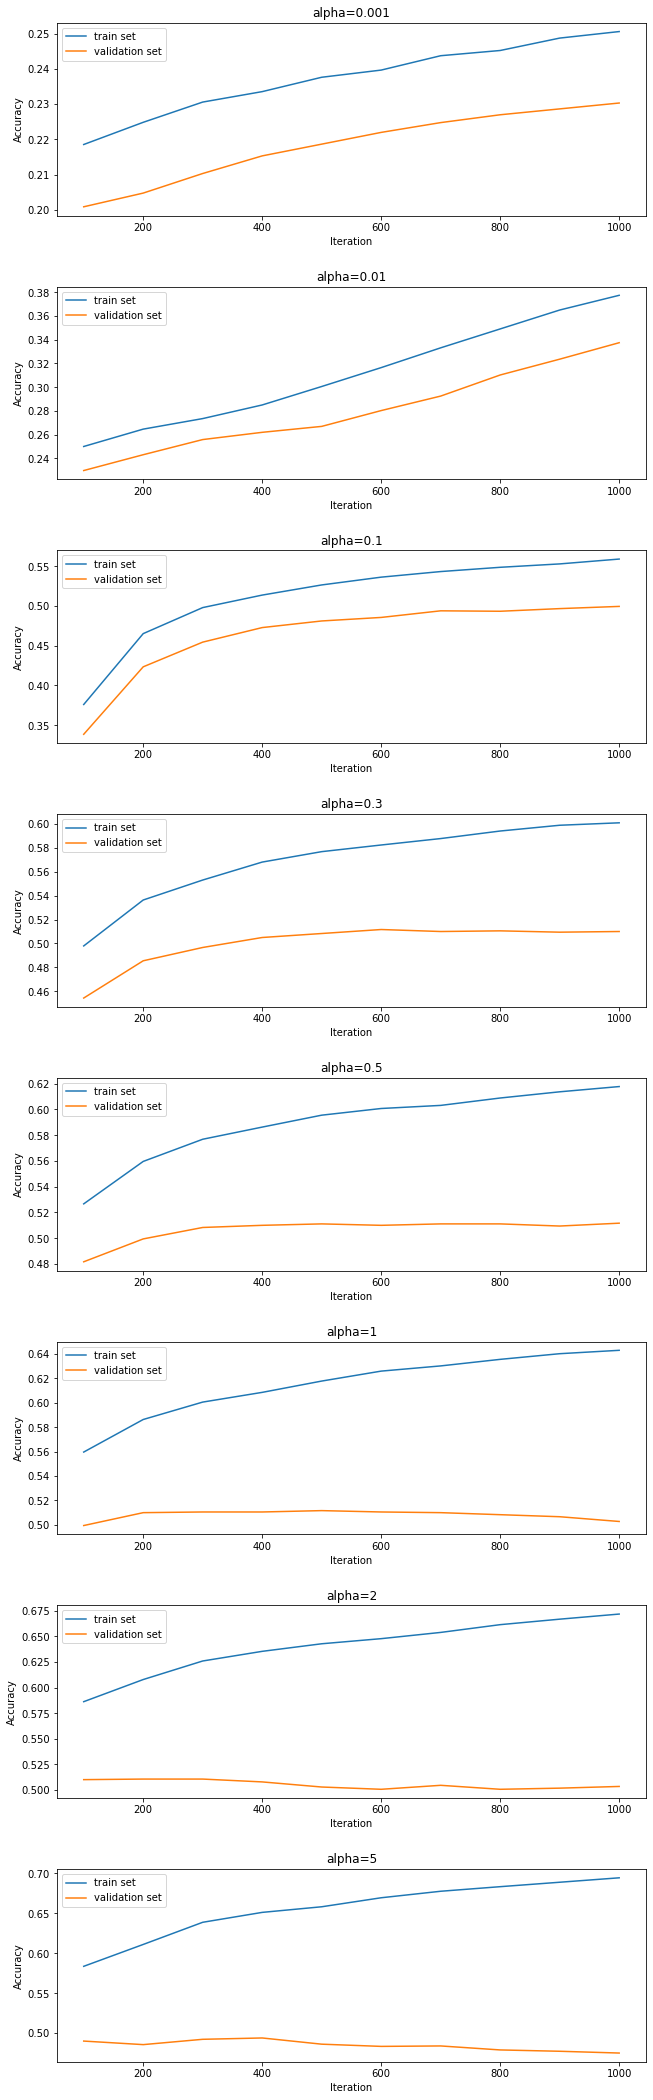

In [26]:
figure, axs = plt.subplots(len(alphas), figsize=(10,30))
figure. tight_layout(pad=5.0)
#figure.suptitle("Model accuracy for differente learning rate values")
for i,alpha in enumerate(alphas):
    all_theta, all_J, pred_all_train, pred_all_val, pred_train_last, pred_val_last = oneVsAll(x_train, y_train, initial_theta, alpha, num_iters, Lambda, len(classes), breakpoint)
    
    print(alpha)
    axs[i].set_title("alpha="+str(alpha))
    axs[i].set(xlabel='Iteration', ylabel='Accuracy')
    
    axs[i].plot([x for x in range(breakpoint,num_iters+breakpoint, breakpoint)], pred_all_train, label='train set')
    axs[i].plot([x for x in range(breakpoint,num_iters+breakpoint, breakpoint)], pred_all_val, label='validation set')
    axs[i].legend()

Validation Accuracy:  0.4911209766925638
Train Accuracy:  0.6230569948186528


Text(0.5, 1.0, 'Cost function using Gradient Descent')

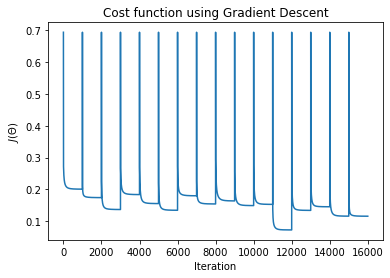

In [75]:
initial_theta = np.zeros((x_train.shape[1]+1,1))
alpha = 1
num_iters=1000
Lambda=10
breakpoint = num_iters

all_theta, all_J, pred_all_train, pred_all_val, pred_train_last, pred_val_last = oneVsAll(x_train, y_train, initial_theta, alpha, num_iters, Lambda, len(classes), breakpoint)

print("Validation Accuracy: ", pred_all_val[-1])
print("Train Accuracy: ", pred_all_train[-1])

plt.plot(all_J)  #All classifiers
#print(all_J)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [76]:
pred = predictOneVsAll(all_theta, x_test)
m = len(y_test)
pred= pred.reshape((len(x_test),1))
print("test acc",sum(np.equal(pred, y_test))[0]/m)

test acc 0.5133185349611543


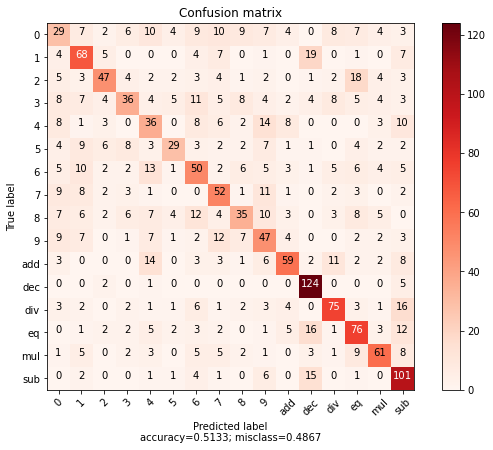

In [83]:
cm = confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes, normalize=False)

0
10
50
100


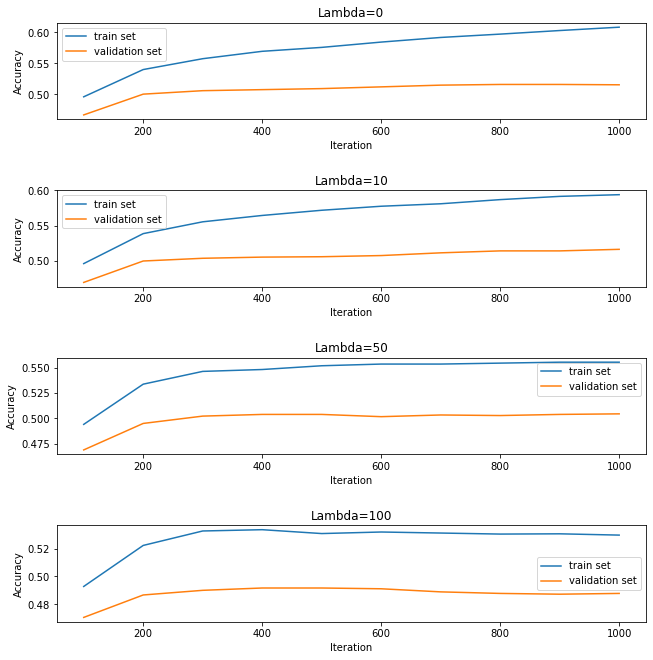

In [20]:
initial_theta = np.zeros((x_train.shape[1]+1,1))
alpha = 0.3
num_iters=1000
Lambdas=[0, 10, 50, 100]
breakpoint = 100

figure, axs = plt.subplots(len(Lambdas), figsize=(10,10))
figure.tight_layout(pad=5.0)

last_train = []
last_val = []
for i,Lambda in enumerate(Lambdas):
    all_theta, all_J, pred_all_train, pred_all_val, pred_train_last, pred_val_last = oneVsAll(x_train, y_train, initial_theta,  alpha, num_iters, Lambda, len(classes), breakpoint)

    last_train.append(pred_train_last)
    last_val.append(pred_val_last)
    print(Lambda)
    axs[i].set_title("Lambda="+str(Lambda))
    axs[i].set(xlabel='Iteration', ylabel='Accuracy')
    
    axs[i].plot([x for x in range(breakpoint,num_iters+breakpoint, breakpoint)], pred_all_train, label='train set')
    axs[i].plot([x for x in range(breakpoint,num_iters+breakpoint, breakpoint)], pred_all_val, label='validation set')
    axs[i].legend()


Text(0, 0.5, 'Accuracy')

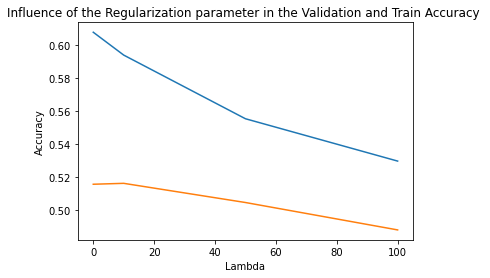

In [21]:
m = len(x_train)
plt.plot([x for x in Lambdas], [sum(np.equal(pred_train,y_train))[0]/m for pred_train in last_train])
m = len(x_val)
plt.plot([x for x in Lambdas], [sum(np.equal(pred_val,y_val))[0]/m for pred_val in last_val])

plt.title("Influence of the Regularization parameter in the Validation and Train Accuracy ")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")

In [28]:
pred = predictOneVsAll(all_theta, x_val)
m = len(y_val)
#Check that pred.shape  = (5000,) => rank 1 array. You need to reshape it !!!
pred= pred.reshape((len(x_val),1))
print("Training Set Accuracy:", sum(np.equal(pred,y_val))[0]/m*100,"%")

Training Set Accuracy: 20.643729189789124 %


In [30]:
pred = predictOneVsAll(all_theta, x_train)
m = len(y_train)
#Check that pred.shape  = (5000,) => rank 1 array. You need to reshape it !!!
pred= pred.reshape((len(x_train),1))
print("Training Set Accuracy:", sum(np.equal(pred,y_train))[0]/m*100,"%")

Training Set Accuracy: 20.799407846039973 %
